# Covid Screenings - Predicting expected Covid Screenings in July


**Process will include:**
  * Inital Exploratory Analysis of the data:
      * Understand features and target
      * Perform data cleaning (if necessary)
  * Feature Extraction & Engineering
  * Additional Exploratory Analysis
  * Time Series Analysis:
      * Using Time series analysis techniques to identify trends and forecast results on unseen data.
  * Supervised Learning: 
      * Using regression techniques to train supervised learning models and compare results on unseen data.

## Inital set-up
* Importing Libraries
* Creating Dataframes
* EDA (Exploratory Data Analysis)

In [1]:
#import libraries for use
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
sns.set_style("white")

/Users/sarajacobi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#import for later use
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

In [3]:
#import csv files for analysis
df = pd.read_csv('screening_data.csv')
df2 = pd.read_csv('visit_data.csv')

#merge the two data frames on the 'Date' column
covid_df = pd.merge(df,df2, how='inner', on='Date')

#review dataframe
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      183 non-null    object
 1   Counts_x  183 non-null    int64 
 2   Counts_y  183 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.7+ KB


In [4]:
#Rename columns for ease of use and clarity
covid_df = covid_df.rename(columns={'Date': 'date','Counts_x':'screening_counts', 'Counts_y' : 'visit_counts'})

In [5]:
#convert date to date_time in pandas
covid_df['date'] = pd.to_datetime(covid_df['date'])

#review new dataframe will not convert date to index yet for possible feature engineering
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              183 non-null    datetime64[ns]
 1   screening_counts  183 non-null    int64         
 2   visit_counts      183 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 5.7 KB


**EDA**

In [6]:
#review head
covid_df.head()

,date,screening_counts,visit_counts
0,2019-12-31,0,257599
1,2020-01-01,0,232750
2,2020-01-02,0,278720
3,2020-01-03,0,239850
4,2020-01-04,0,25200


In [7]:
#review tail
covid_df.tail()

,date,screening_counts,visit_counts
178,2020-06-26,181732,382530
179,2020-06-27,17280,40560
180,2020-06-28,13440,23520
181,2020-06-29,245752,448470
182,2020-06-30,193200,455000


In [8]:
#look at descriptive statistics 
covid_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
screening_counts,183.0,52541.360656,77816.975136,0.0,0.0,6120.0,104527.5,248017.0
visit_counts,183.0,219867.819672,145048.570962,7600.0,34860.0,264670.0,325480.0,478670.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7e6bdfd50>,
      dtype=object)

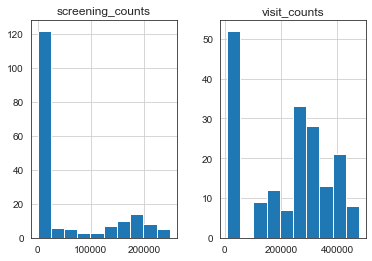

In [9]:
#visualize
covid_df.hist()

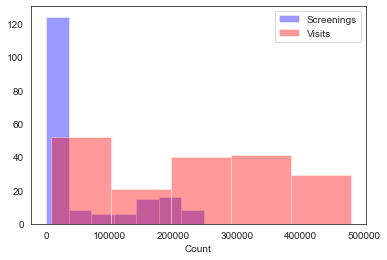

In [10]:
#compare distributions of continuous variables
sns.distplot(covid_df['screening_counts'], kde=False, color='blue', label = "Screenings")
sns.distplot(covid_df['visit_counts'], kde=False, color= 'red', label= "Visits")

#plot variables
plt.xlabel('Count')
plt.legend()
plt.savefig('count.png')
plt.show()

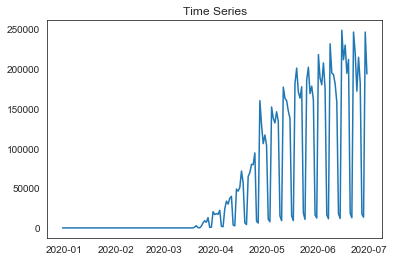

In [11]:
#visualize dates and screenings to identify trends
plt.plot(covid_df.date, covid_df.screening_counts)
plt.title('Time Series')
plt.show()

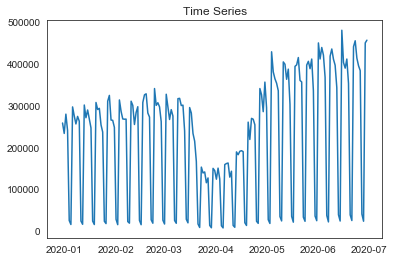

In [12]:
#visualize dates and visits to identify trends
plt.plot(covid_df.date, covid_df.visit_counts)
plt.title('Time Series')
plt.show()

## Models for Machine Learning

### Model 1 Feature engineering
    

In [13]:
#create new dataframe for our first model
covid_features = covid_df[['date',  'visit_counts', 'screening_counts']]
covid_features.head()

,date,visit_counts,screening_counts
0,2019-12-31,257599,0
1,2020-01-01,232750,0
2,2020-01-02,278720,0
3,2020-01-03,239850,0
4,2020-01-04,25200,0


In [14]:
#locating first dates screenings recorded for potential variable imputation
covid_df.loc[covid_df['date']>= '2020-03-15'][:10]

,date,screening_counts,visit_counts
75,2020-03-15,0,19680
76,2020-03-16,0,294450
77,2020-03-17,0,281400
78,2020-03-18,0,232750
79,2020-03-19,1005,214400
80,2020-03-20,2767,166050
81,2020-03-21,360,17040
82,2020-03-22,120,8640
83,2020-03-23,2265,152510
84,2020-03-24,6300,138600


In [15]:
#create variable for first recorded screening
first = pd.to_datetime('2020-03-19')

#create feature for variance from first screening date
covid_features['date_screened'] =  covid_features['date'] - first
covid_features['date_screened'] = covid_features.date_screened.dt.days
covid_features.tail()

,date,visit_counts,screening_counts,date_screened
178,2020-06-26,382530,181732,99
179,2020-06-27,40560,17280,100
180,2020-06-28,23520,13440,101
181,2020-06-29,448470,245752,102
182,2020-06-30,455000,193200,103


In [16]:
#create new features from date data for machine learning model
covid_features['date_month'] = covid_features['date'].dt.month
covid_features['date_week'] = covid_features['date'].dt.week
covid_features['date_day'] = covid_features['date'].dt.day
covid_features['date_weekday'] = covid_features['date'].dt.dayofweek

#drop date from features 
covid_features = covid_features.drop('date', axis=1)

#review
covid_features.head()

,visit_counts,screening_counts,date_screened,date_month,date_week,date_day,date_weekday
0,257599,0,-79,12,1,31,1
1,232750,0,-78,1,1,1,2
2,278720,0,-77,1,1,2,3
3,239850,0,-76,1,1,3,4
4,25200,0,-75,1,1,4,5


In [17]:
#create new feature differencing both screening and visits

#differencing in screening counts using shift for stationarity
covid_features['diff_screen'] = covid_features.screening_counts - covid_features.screening_counts.shift()
#fill null values using backfill
covid_features['diff_screen'] = covid_features.diff_screen.fillna(method='bfill')

#differencing in visit counts using shift for stationarity
covid_features['diff_visit'] = covid_features.visit_counts - covid_features.visit_counts.shift()
#fill null values using backfill
covid_features['diff_visit'] = covid_features.diff_visit.fillna(value=0)

#Review
covid_features.head()

,visit_counts,screening_counts,date_screened,date_month,date_week,date_day,date_weekday,diff_screen,diff_visit
0,257599,0,-79,12,1,31,1,0.0,0.0
1,232750,0,-78,1,1,1,2,0.0,-24849.0
2,278720,0,-77,1,1,2,3,0.0,45970.0
3,239850,0,-76,1,1,3,4,0.0,-38870.0
4,25200,0,-75,1,1,4,5,0.0,-214650.0


In [18]:
#create feature showing the difference in screening's and visits
covid_features['visit_vs_screen'] = (covid_features.visit_counts - covid_features.screening_counts)/2

covid_features.tail(20)

,visit_counts,screening_counts,date_screened,date_month,date_week,date_day,date_weekday,diff_screen,diff_visit,visit_vs_screen
163,395300,180900,84,6,24,11,3,-11617.0,-14340.0,107200.0
164,341940,157747,85,6,24,12,4,-23153.0,-53360.0,92096.5
165,38880,17910,86,6,24,13,5,-139837.0,-303060.0,10485.0
166,24000,11880,87,6,24,14,6,-6030.0,-14880.0,6060.0
167,478670,248017,88,6,25,15,0,236137.0,454670.0,115326.5
168,401800,211050,89,6,25,16,1,-36967.0,-76870.0,95375.0
169,388360,229425,90,6,25,17,2,18375.0,-13440.0,79467.5
170,410040,193965,91,6,25,18,3,-35460.0,21680.0,108037.5
171,351780,211252,92,6,25,19,4,17287.0,-58260.0,70264.0
172,38640,18540,93,6,25,20,5,-192712.0,-313140.0,10050.0


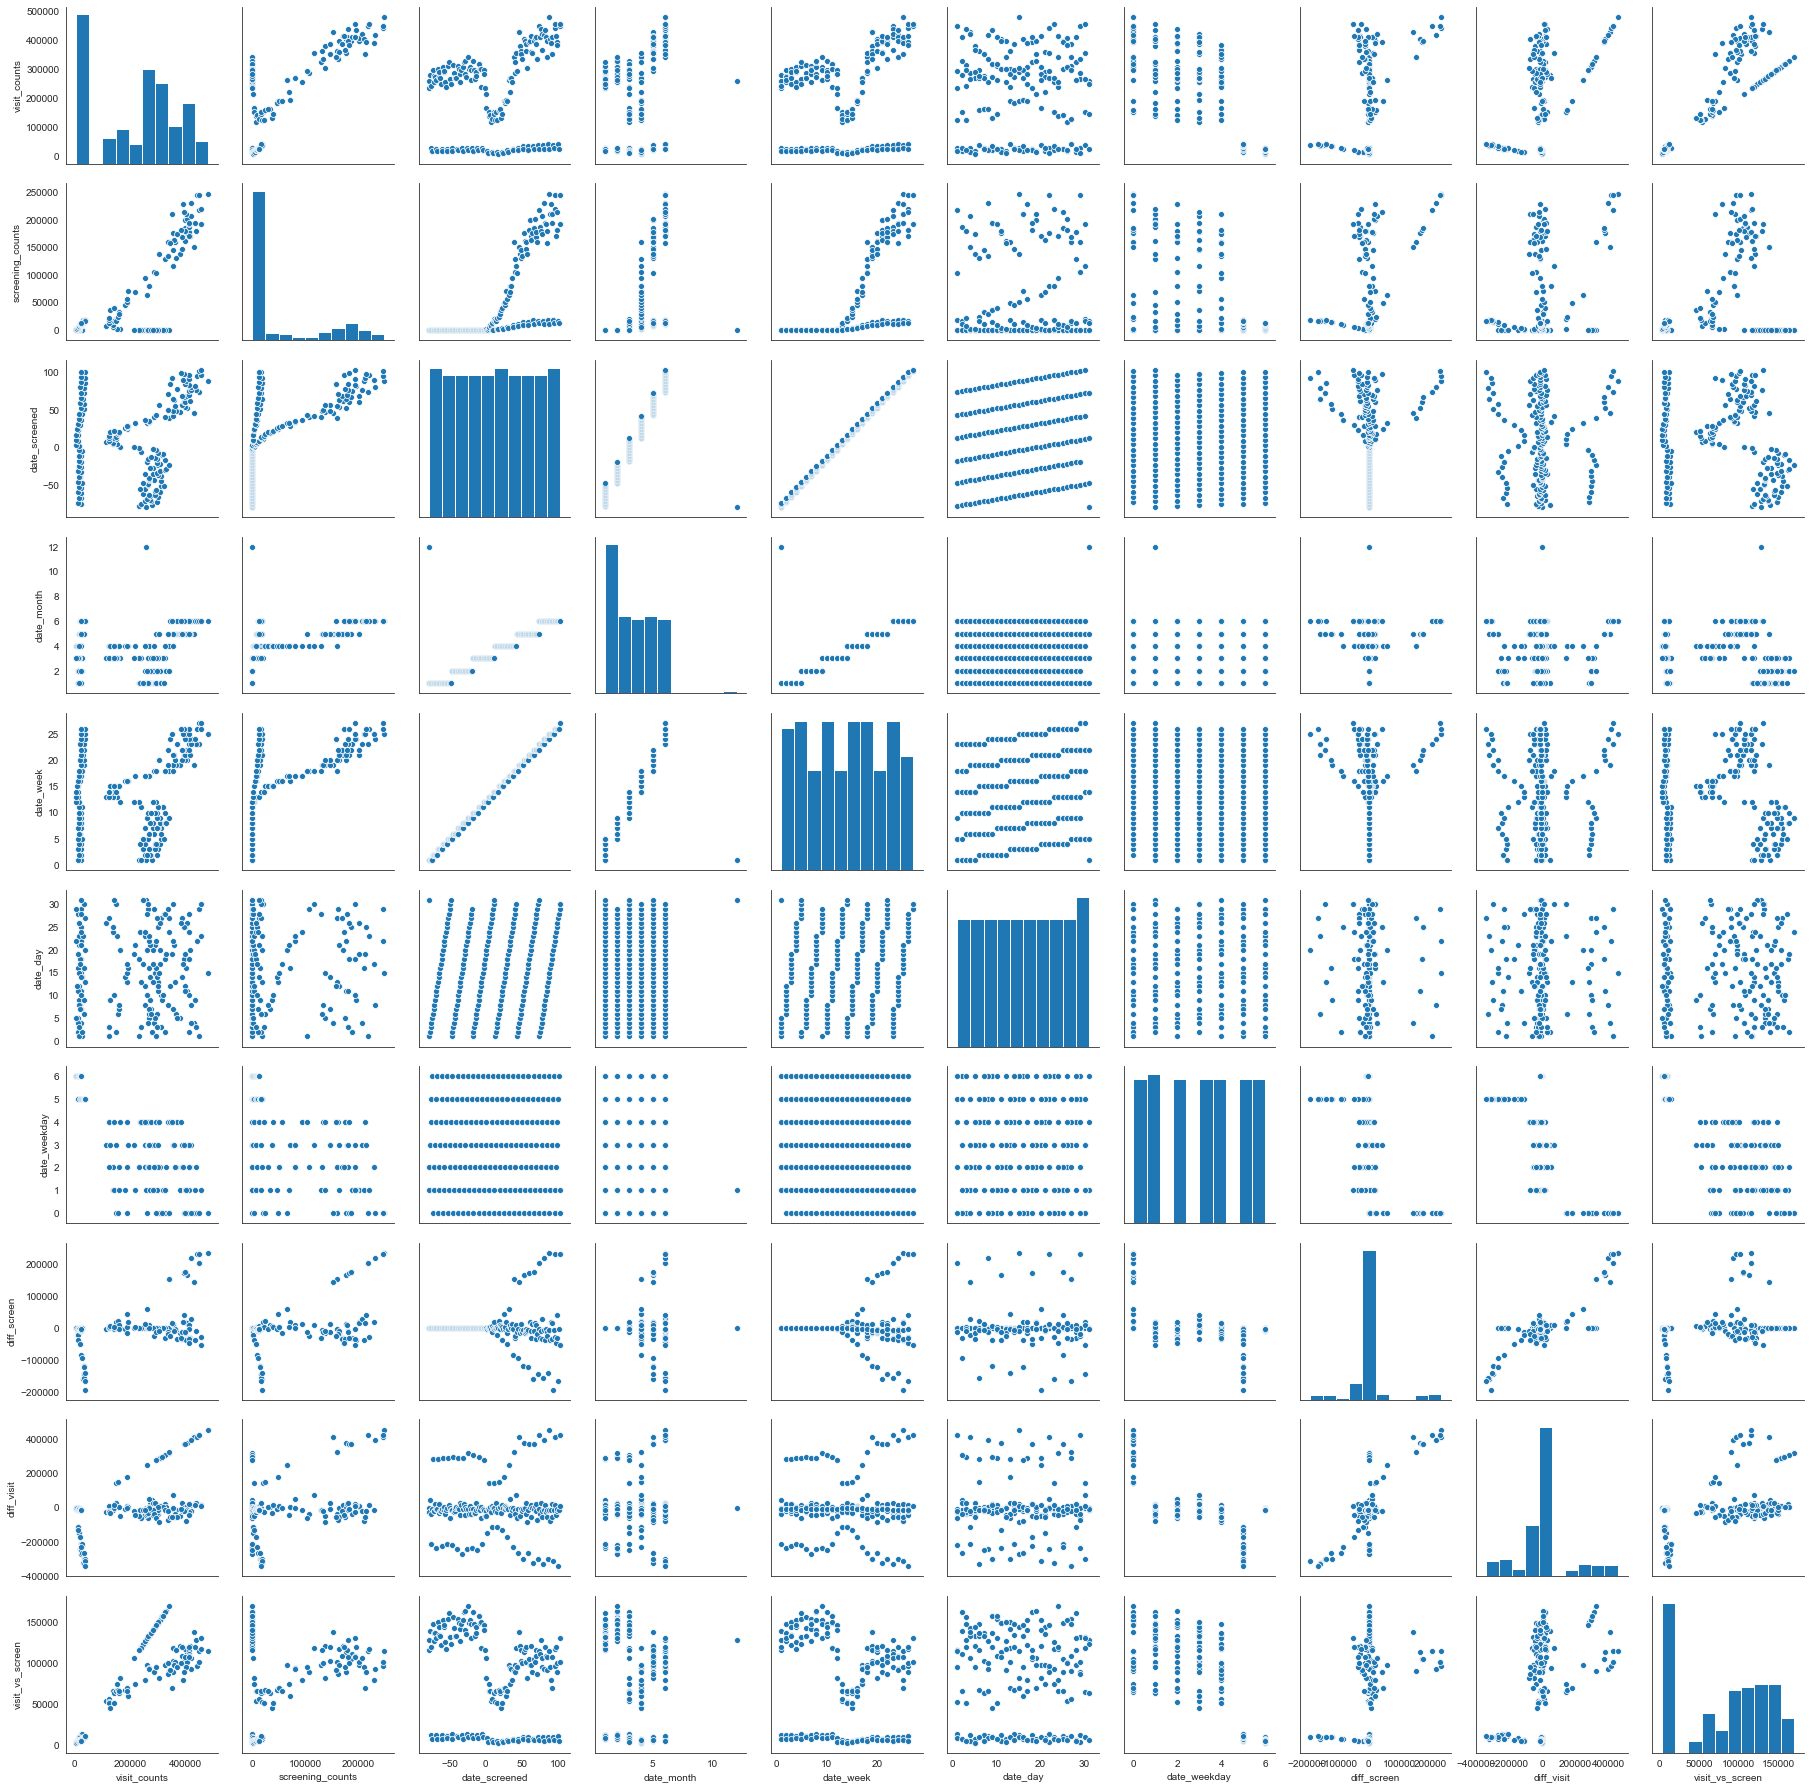

In [19]:
#visualize features in pairplot
sns.pairplot(covid_features)

In [20]:
#review descriptive statistics of new features
covid_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
visit_counts,183.0,219867.819672,145048.570962,7600.0,34860.0,264670.0,325480.0,478670.0
screening_counts,183.0,52541.360656,77816.975136,0.0,0.0,6120.0,104527.5,248017.0
date_screened,183.0,12.000000,52.971691,-79.0,-33.5,12.0,57.5,103.0
date_month,183.0,3.546448,1.820752,1.0,2.0,4.0,5.0,12.0
date_week,183.0,13.715847,7.572806,1.0,7.0,14.0,20.0,27.0
date_day,183.0,15.759563,8.840286,1.0,8.0,16.0,23.0,31.0
date_weekday,183.0,2.989071,2.005457,0.0,1.0,3.0,5.0,6.0
diff_screen,183.0,1055.737705,58435.610317,-192712.0,-4470.0,0.0,0.0,236137.0
diff_visit,183.0,1078.693989,155083.419411,-341970.0,-39105.0,-10670.0,10215.0,454670.0
visit_vs_screen,183.0,83663.229508,54279.960503,3050.0,12600.0,97584.0,130947.5,169874.5


### Model 2 : Create new datafram and transform variables for comparison only using screening counts > 100

In [21]:
#create new dataframe including only screening counts more than 100
covid_features_2 = covid_features.loc[covid_features['screening_counts']>100]
covid_features_2.shape

(104, 10)

In [22]:
#transform screening and visit counts into boxcox variable for analysis
from scipy.stats import boxcox

screening_counts,_ = boxcox(covid_features_2['screening_counts'])
visit_counts,_ = boxcox(covid_features_2['visit_counts'])

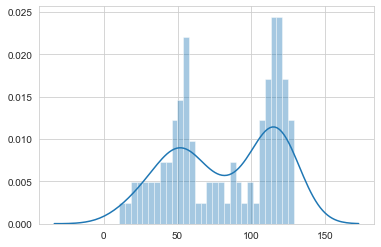

In [23]:
#visualize transformed screenings
sns.set_style('whitegrid')
ax = sns.distplot(screening_counts, bins=30)

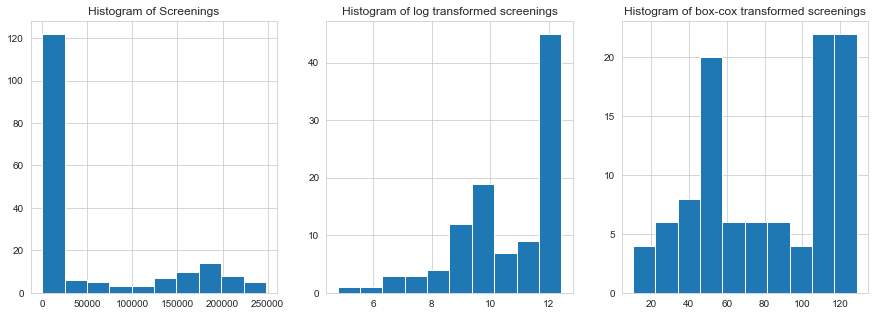

In [24]:
#compare all versions of screenings
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.hist(covid_df["screening_counts"])
plt.title("Histogram of Screenings")

plt.subplot(1,3,2)
plt.hist(np.log(covid_features_2["screening_counts"]))
plt.title("Histogram of log transformed screenings")

plt.subplot(1,3,3)
plt.hist(screening_counts)
plt.title("Histogram of box-cox transformed screenings")
plt.show()

In [25]:
#adding transformed variables to new dataframe for later use
covid_features_2['screening_transformed'] = screening_counts

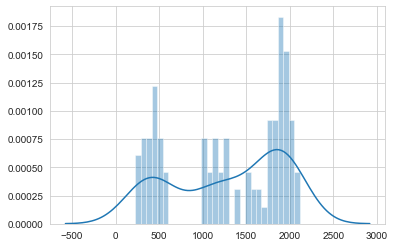

In [26]:
#visualize transformed 
sns.set_style('whitegrid')
ax = sns.distplot(visit_counts, bins=30)

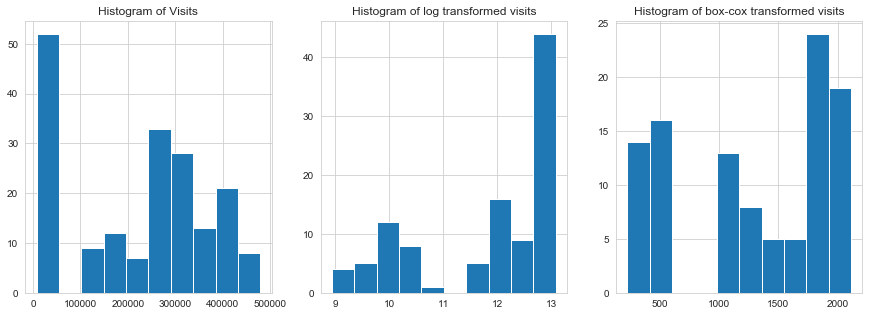

In [27]:
#compare distributions for all visit counts
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.hist(covid_df["visit_counts"])
plt.title("Histogram of Visits")

plt.subplot(1,3,2)
plt.hist(np.log(covid_features_2["visit_counts"]))
plt.title("Histogram of log transformed visits")

plt.subplot(1,3,3)
plt.hist(visit_counts)
plt.title("Histogram of box-cox transformed visits")
plt.show()

In [28]:
#adding transformed variables to new dataframe for later use
covid_features_2['visit_transformed'] = visit_counts

### Model 1- Evaluation feature importance

In [29]:
#create features and target variable for model
X = covid_features.drop('screening_counts', axis=1)
y = covid_features['screening_counts']

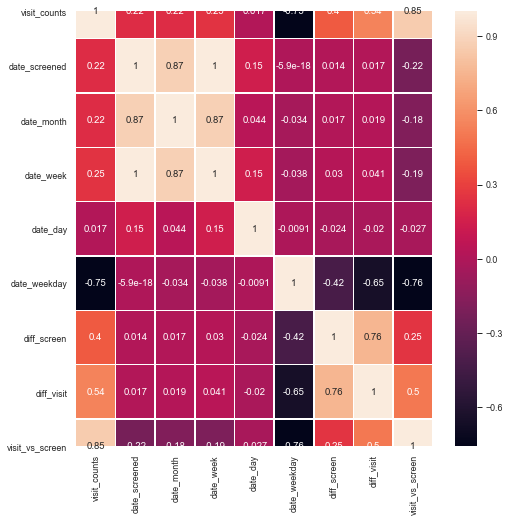

In [30]:
#review correlations
X_corr = X.corr()

sns.set_context("paper")
plt.figure(figsize=(8,8))
sns.heatmap(X_corr, annot=True, linewidths=.5)
plt.show()

In [31]:
#now look at VIF to find feature importance

#import statsmodel
from statsmodels.stats.outliers_influence import variance_inflation_factor

#add constant
X_sm = sm.add_constant(X)

vif = pd.DataFrame()
vif["VIF_factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF_factor,features
0,14.8,visit_counts
1,17.1,date_screened
2,4.4,date_month
3,75.0,date_week
4,1.1,date_day
5,9.4,date_weekday
6,3.4,diff_screen
7,3.9,diff_visit
8,15.3,visit_vs_screen


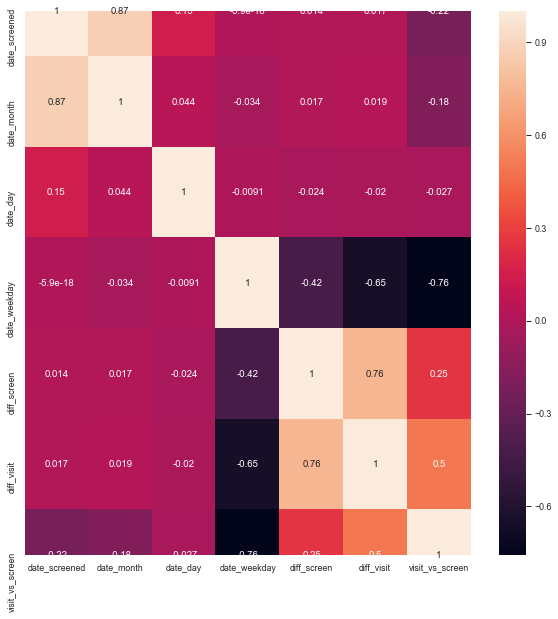

In [32]:
#will drop features from VIF that are too high 
X = X.drop(columns=['visit_counts','date_week'], axis=1)
X_corr = X.corr()

sns.set_context('paper')
plt.figure(figsize=(10,10))
sns.heatmap(X_corr, annot=True)
plt.show()

In [33]:
#review new VIF
X_sm = sm.add_constant(X)

vif = pd.DataFrame()
vif["VIF_factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF_factor,features
0,3.9,date_screened
1,12.7,date_month
2,3.8,date_day
3,5.2,date_weekday
4,2.5,diff_screen
5,3.5,diff_visit
6,5.2,visit_vs_screen


I could remove the date_month, but will leave it in for now

### Split LIMITED data into trainig and test set 

In [34]:
#inital model split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model 2- Second data frame only using screening counts > 100

In [35]:
#create features and target variable for model
X2 = covid_features_2.drop(['screening_counts', 'screening_transformed'], axis=1)
y2 = covid_features_2['screening_transformed']

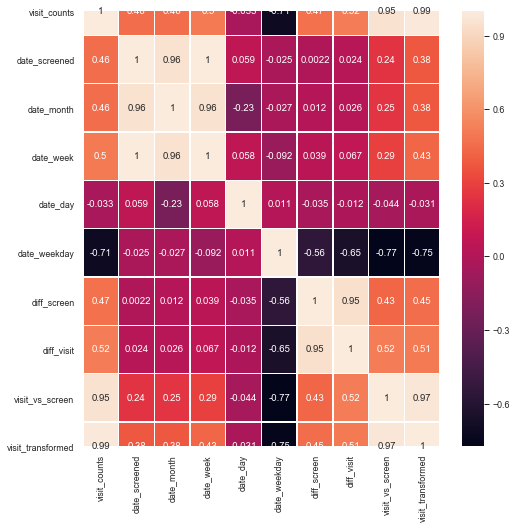

In [36]:
#visualize correlations
X_corr_2 = X2.corr()

sns.set_context("paper")
plt.figure(figsize=(8,8))
sns.heatmap(X_corr_2, annot=True, linewidths=.5)
plt.show()

In [37]:
#now look at VIF to find feature importance

#add constant
X_sm = sm.add_constant(X2)

vif = pd.DataFrame()
vif["VIF_factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif.round(1)

,VIF_factor,features
0,79.3,visit_counts
1,5270.7,date_screened
2,18892.9,date_month
3,620440.7,date_week
4,1550.7,date_day
5,443.7,date_weekday
6,19.8,diff_screen
7,20.9,diff_visit
8,54.4,visit_vs_screen
9,99.5,visit_transformed


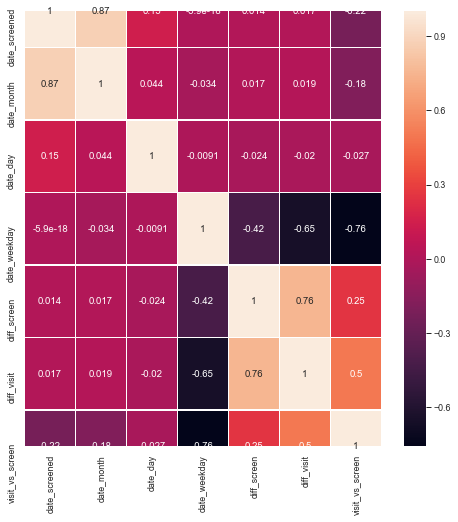

In [38]:
#will drop features from VIF that are too high 
X2 = X2.drop(columns=['visit_counts','date_week', 'visit_transformed','diff_visit', 'date_month'], axis=1)
X_corr_2 = X2.corr()

sns.set_context("paper")
plt.figure(figsize=(8,8))
sns.heatmap(X_corr, annot=True, linewidths=.5)
plt.show()

In [39]:
#now look at VIF to find feature importance

#import statsmodel
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_sm2 = sm.add_constant(X2)

vif = pd.DataFrame()
vif["VIF_factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif.round(1)

,VIF_factor,features
0,4.5,date_screened
1,3.9,date_day
2,3.4,date_weekday
3,1.4,diff_screen
4,3.9,visit_vs_screen


### Split second dataframe into training and test sets

In [40]:
#inital model split into training and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Time Series Review

In [41]:
#Use origianl dataframe and set date as index
covid_time = covid_df
covid_time['date'] = pd.to_datetime(covid_df['date'])

#set index to date and drop column
covid_time.index = pd.to_datetime(covid_df.date)
covid_time = covid_time.drop('date', axis=1)

#review new dataframe
covid_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2019-12-31 to 2020-06-30
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   screening_counts  183 non-null    int64
 1   visit_counts      183 non-null    int64
dtypes: int64(2)
memory usage: 4.3 KB


### Stationarity

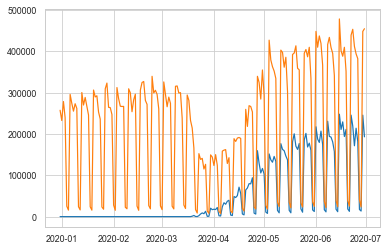

In [42]:
plt.plot(covid_time)

It’s clear from the plot that there is an overall increase in the trend,with some seasonality in it.

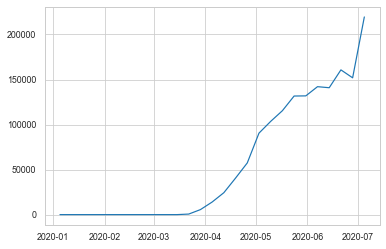

In [43]:
#visualize screening means for week
m = covid_time['screening_counts'].resample('W').mean()
plt.plot(m)

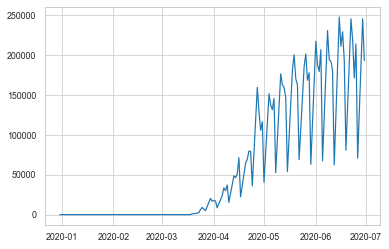

In [44]:
#visualize screening count means by business day
m_bday = covid_time['screening_counts'].resample('B').mean()
plt.plot(m_bday)

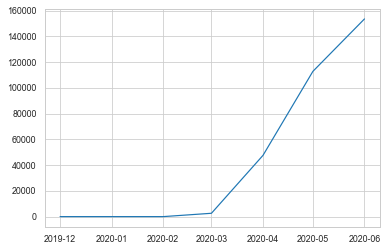

In [45]:
#visualize screening count means by month
m_month = covid_time['screening_counts'].resample('MS').mean()
plt.plot(m_month)

### Differencing

In [46]:
#differencing in screening counts using shift for stationarity
covid_time['diff_1'] = covid_time.screening_counts - covid_time.screening_counts.shift()
#fill null values using backfill
covid_time['diff_1'] = covid_time.diff_1.fillna(method='bfill')
#view new variable
print(covid_time.head())
print(covid_time.diff_1.describe())

            screening_counts  visit_counts  diff_1
date                                              
2019-12-31                 0        257599     0.0
2020-01-01                 0        232750     0.0
2020-01-02                 0        278720     0.0
2020-01-03                 0        239850     0.0
2020-01-04                 0         25200     0.0
count       183.000000
mean       1055.737705
std       58435.610317
min     -192712.000000
25%       -4470.000000
50%           0.000000
75%           0.000000
max      236137.000000
Name: diff_1, dtype: float64


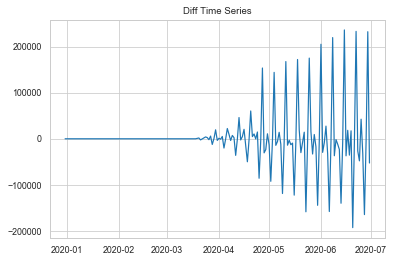

In [47]:
#visualize diff in relation to date
plt.plot(covid_df.date, covid_time.diff_1)
plt.title('Diff Time Series')
plt.show()

            screening_counts  visit_counts    diff_1
date                                                
2020-04-25              8460         23400  -85635.0
2020-05-02             11070         27120  -92250.0
2020-05-09             15030         34680 -118732.0
2020-05-16             15209         35040 -122243.0
2020-05-23             18720         33240 -158400.0
2020-05-30             16200         35880 -144314.0
2020-06-06             16560         37200 -157792.0
2020-06-13             17910         38880 -139837.0
2020-06-20             18540         38640 -192712.0
2020-06-27             17280         40560 -164452.0
2020-06-30            193200        455000  -52552.0


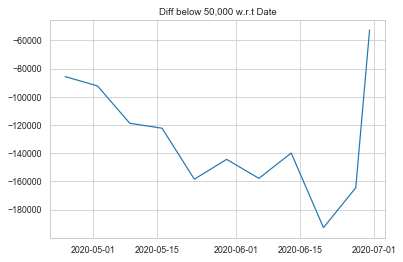

In [48]:
#look at diff less than 50000
print(covid_time.loc[covid_time['diff_1'] < -50000])
#visualize difference
plt.plot(covid_time.loc[covid_time['diff_1'] < -50000].diff_1 )
plt.title('Diff below 50,000 w.r.t Date')
plt.show()

### Skew

In [49]:
#look at screening counts less than 100
covid_time.loc[covid_time['screening_counts']<100]

,screening_counts,visit_counts,diff_1
date,,,
2019-12-31,0,257599,0.0
2020-01-01,0,232750,0.0
2020-01-02,0,278720,0.0
2020-01-03,0,239850,0.0
2020-01-04,0,25200,0.0
...,...,...,...
2020-03-14,0,28080,0.0
2020-03-15,0,19680,0.0
2020-03-16,0,294450,0.0


In [50]:
#create new dataframe including only screening counts more than 100
covid_df_2 = covid_time.loc[covid_time['screening_counts']>100]
covid_df_2.shape

(104, 3)

In [51]:
#from new dataframe look at screening counts less than 1000
covid_df_2.loc[covid_df_2['screening_counts']<1000]

,screening_counts,visit_counts,diff_1
date,,,
2020-03-21,360,17040,-2407.0
2020-03-22,120,8640,-240.0
2020-03-28,630,13560,-12285.0
2020-03-29,900,7920,270.0


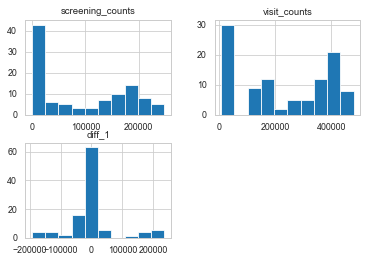

In [52]:
#reviewing distributions of new df
covid_time.loc[covid_time['screening_counts']>100].hist()
plt.show()

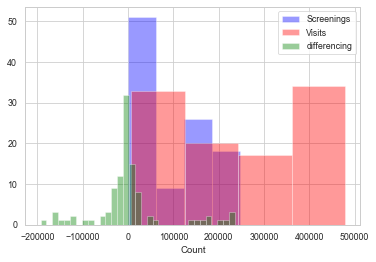

In [53]:
#comparing distributions of new df
sns.distplot(covid_df_2['screening_counts'], kde=False, color='blue', label = "Screenings")
sns.distplot(covid_df_2['visit_counts'], kde=False, color= 'red', label= "Visits")
sns.distplot(covid_df_2['diff_1'], kde=False, color= 'green', label= "differencing")


plt.xlabel('Count')
plt.legend()
plt.savefig('count.png')
plt.show()

### Look at PACF for both the initial and differenced time series.

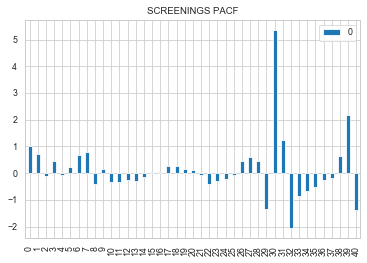

In [54]:
from statsmodels.tsa.stattools import pacf

x_acf = pd.DataFrame(pacf(covid_time.screening_counts))
x_acf.plot(kind='bar')
plt.title("SCREENINGS PACF")
plt.show()

Text(0.5, 1.0, 'DIFF PACF')

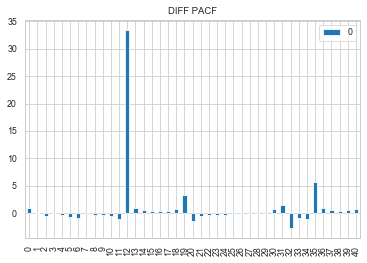

In [55]:
x_acf_diff = pd.DataFrame(pacf(covid_time.diff_1))
x_acf_diff.plot(kind='bar')
plt.title("DIFF PACF")

### Decomposition

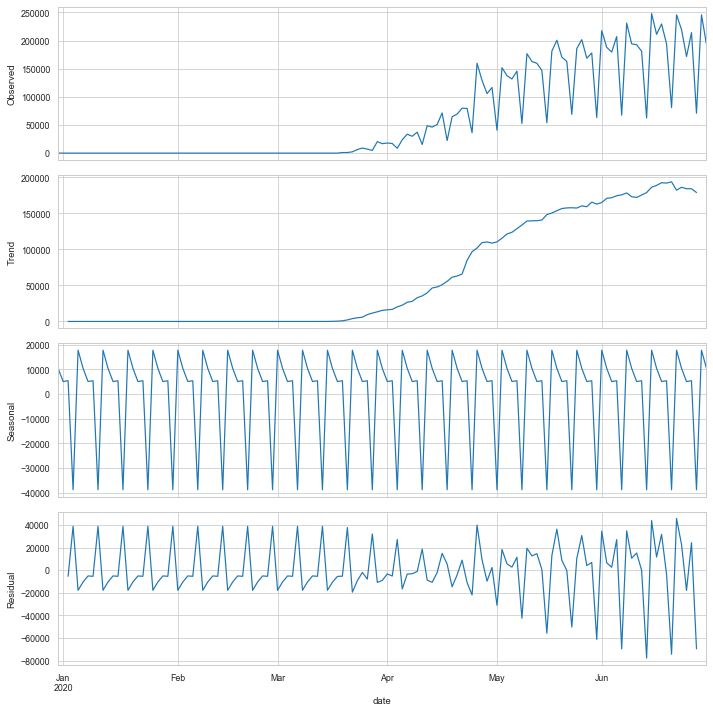

In [56]:
#review decomposition of series
from pylab import rcParams

#start with business day
rcParams['figure.figsize'] = 10, 10
decomposition = sm.tsa.seasonal_decompose(m_bday, model='additive')
fig = decomposition.plot()
plt.show()

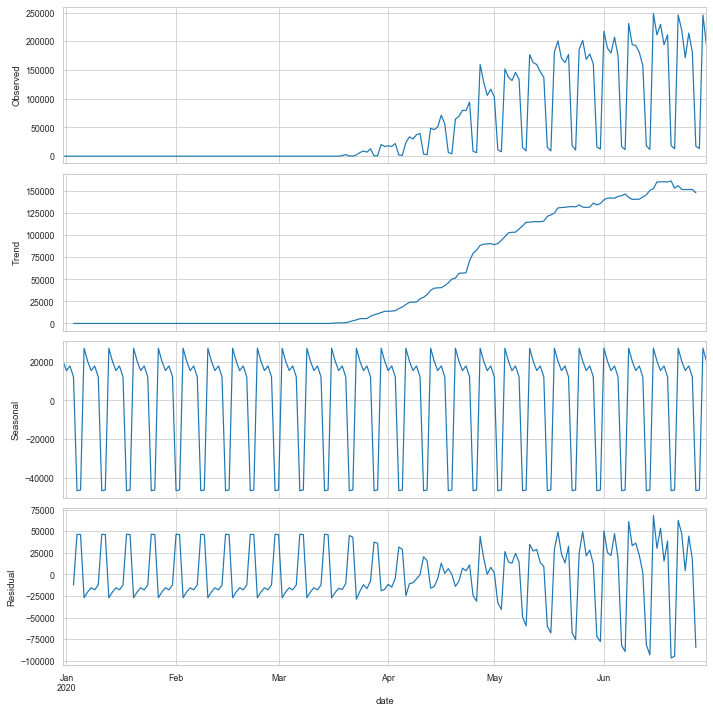

In [57]:
#screening first dataframe
rcParams['figure.figsize'] = 10, 10
decomposition2 = sm.tsa.seasonal_decompose(covid_time['screening_counts'], model='additive')
fig2 = decomposition2.plot()
plt.show()

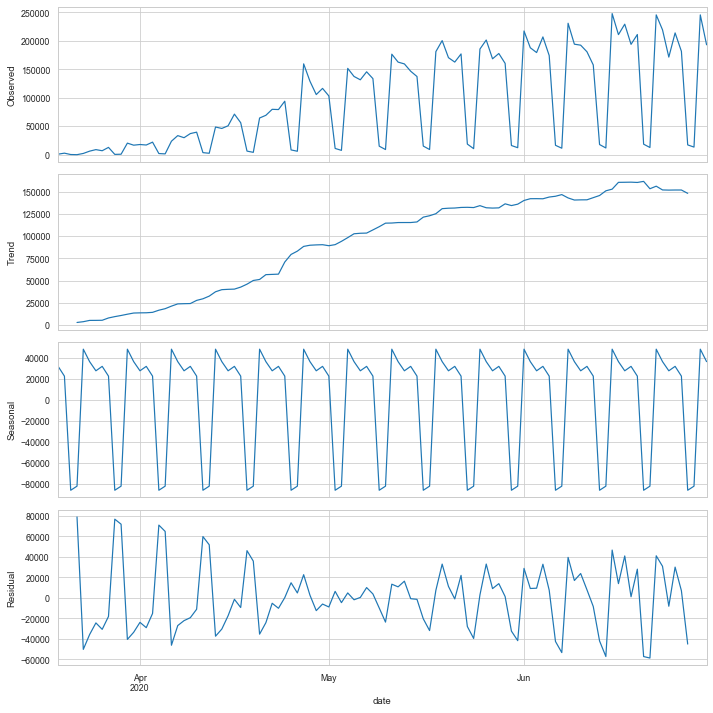

In [58]:
#screening second data frame
rcParams['figure.figsize'] = 10, 10
decomposition2 = sm.tsa.seasonal_decompose(covid_df_2['screening_counts'], model='additive')
fig2 = decomposition2.plot()
plt.show()

## ARIMA

### Parameter Tuning

In [59]:
#create variables to check for optimal parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [60]:
#run algorithm to select optimal parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(covid_time.screening_counts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4686.580603468403
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4354.117595243476
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4316.433489001797
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3992.666143345237
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4326.243335853182
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4269.471256476021
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4012.614737135014
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3982.0000807233996
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4528.016097896507
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4226.365328434018
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4221.267599636072
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3896.2356041985386
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4267.852642197739
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4208.946046294825
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3944.5990415725946
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3894.949496195625
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4489.919790927409
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4147.085646065671
ARIMA(0

### Model

In [61]:
###from above select lowest AIC : ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:3893.783115436554

#import model
from statsmodels.tsa.arima_model import ARIMA

#run model on above parameters
model_101 = ARIMA(covid_time.screening_counts, order=(1,0, 1))
model_101_fit = model_101.fit()
print(model_101_fit.summary())
print('Residuals Description')
print(model_101_fit.resid.describe())

forecast, stderr, conf = model_101_fit.forecast()

                              ARMA Model Results                              
Dep. Variable:       screening_counts   No. Observations:                  183
Model:                     ARMA(1, 1)   Log Likelihood               -2247.425
Method:                       css-mle   S.D. of innovations          51998.810
Date:                Fri, 25 Sep 2020   AIC                           4502.850
Time:                        08:11:33   BIC                           4515.688
Sample:                    12-31-2019   HQIC                          4508.054
                         - 06-30-2020                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   5.254e+04   1.01e+04      5.223      0.000    3.28e+04    7.23e+04
ar.L1.screening_counts     0.3728      0.133      2.812      0.005       0.113       0.633
ma.L

In [62]:
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Forecast: 71678.270
Standard Error: 51998.810
95% Prediction Interval: -30237.524 to 173594.064


In [63]:
#run SARIMAX with all parameters from above highest performer
mod = sm.tsa.statespace.SARIMAX(covid_time.screening_counts, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                   screening_counts   No. Observations:                  183
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1941.892
Date:                            Fri, 25 Sep 2020   AIC                           3893.783
Time:                                    08:11:33   BIC                           3909.064
Sample:                                12-31-2019   HQIC                          3899.989
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0846      0.154     -0.548      0.584      -0.387       0.218
ma.L1          0.9250      0.049   

Text(0.5, 1.0, 'Histogram of Residuals')

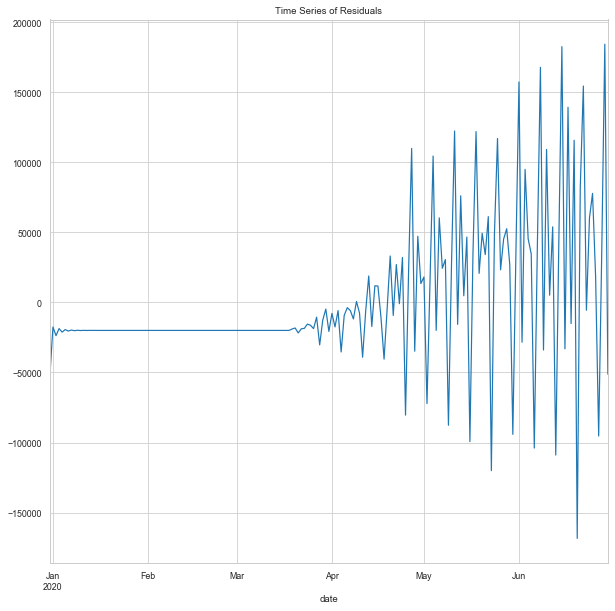

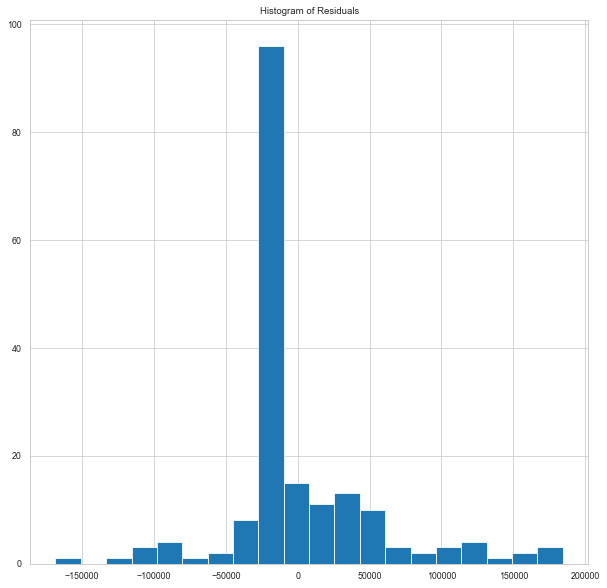

In [64]:
#create dataframe of residuals
residuals = pd.DataFrame(model_101_fit.resid)

#plot residuals from model
residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

## Forecasting

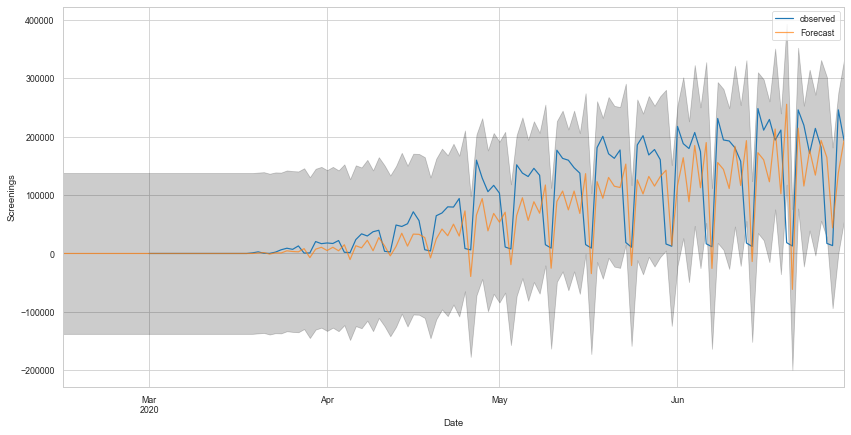

In [65]:
#review rolling forecast predictions
pred = results.get_prediction(start=pd.to_datetime('2020-02-15'), dynamic=False)
pred_ci = pred.conf_int()
ax = covid_time.screening_counts['2020-03':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Screenings')
plt.legend()
plt.show()

In [66]:
#pull MSE and RMSE from forecast
pred_forecasted = pred.predicted_mean
screening = covid_time.screening_counts['2020-03-01':]
mse = ((pred_forecasted - screening) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 3686516281.93
The Root Mean Squared Error of our forecasts is 60716.69


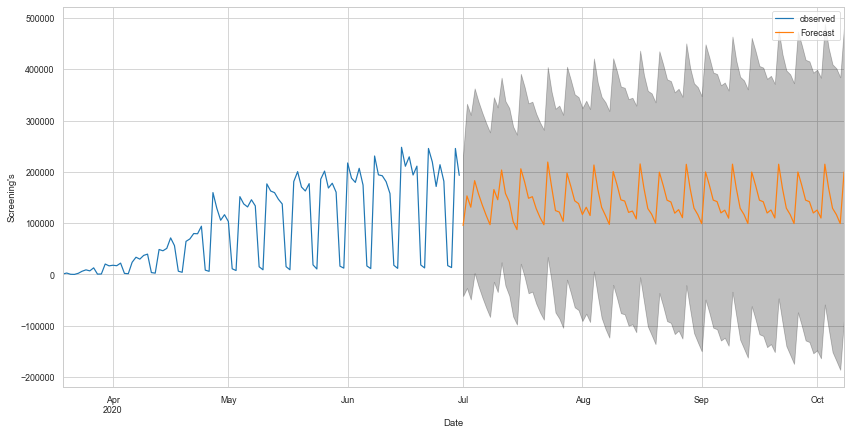

In [67]:
#display confidnece interval and uncertainty
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = covid_df_2.screening_counts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel("Screening's")
plt.legend()
plt.show()

## Conclusion
Looking at the visuals we can assume that July will produce +300K Screenings on any given weekday (business day). With a 95% confidence interval we can anticipate that based on the limited data, trend and seasonaility it will fall between 0-400,000 in the month of July.

# Machine Learning Models

## OLS Regression Model

### Model 1

In [68]:
#using model 1 prepared and assessed above

#add constant for statsmodel
X_train_sm = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train_sm).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       screening_counts   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     63.39
Date:                Fri, 25 Sep 2020   Prob (F-statistic):           4.99e-40
Time:                        08:11:35   Log-Likelihood:                -1746.1
No. Observations:                 146   AIC:                             3508.
Df Residuals:                     138   BIC:                             3532.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2134.1131   2.13e+04     

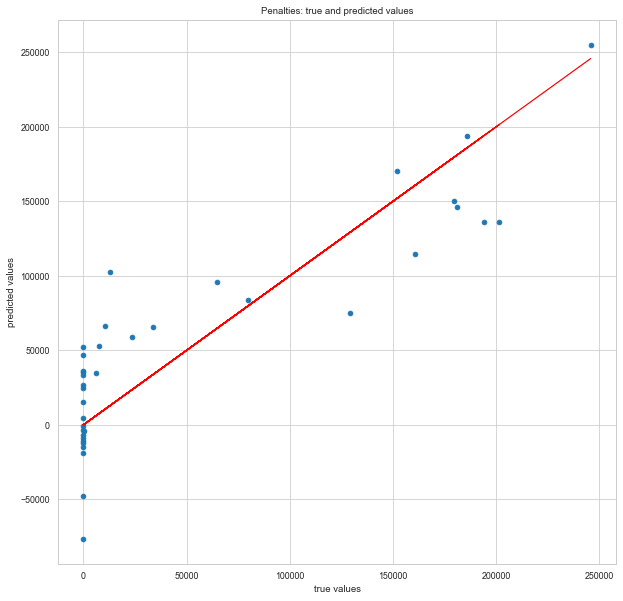

In [69]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test_sm = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test_sm)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Penalties: true and predicted values")
plt.show()

In [70]:
#Linear Regression model
lrm = LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X_train, y_train)
# Predicting
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs(
    (y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.7627863151618316
-----Test set statistics-----
R-squared of the model in test set is: 0.7661955714235111
Mean absolute error of the prediction is: 30498.446459708666
Root mean squared error of the prediction is: 37451.75792957417
Mean absolute percentage error of the prediction is: inf


In [71]:
#scale data using standard scaler in test set to compare results
scaler = StandardScaler()

normalized_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
lrm.fit(normalized_X_train, y_train)


y_test_pred = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: -1215830737.9977999
-----Test set statistics-----
R-squared of the model in test set is: -1259266005.141188
Mean absolute error of the prediction is: 30498.446459708666
Root mean squared error of the prediction is: 37451.75792957417
Mean absolute percentage error of the prediction is: inf


###  Model 2

In [72]:
#using second model from above to test on OLS
X_train_sm2 = sm.add_constant(X_train2)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train2, X_train_sm2).fit()

# We print the summary results
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     screening_transformed   R-squared:                       0.914
Model:                               OLS   Adj. R-squared:                  0.908
Method:                    Least Squares   F-statistic:                     163.4
Date:                   Fri, 25 Sep 2020   Prob (F-statistic):           1.67e-39
Time:                           08:11:36   Log-Likelihood:                -308.33
No. Observations:                     83   AIC:                             628.7
Df Residuals:                         77   BIC:                             643.2
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const       

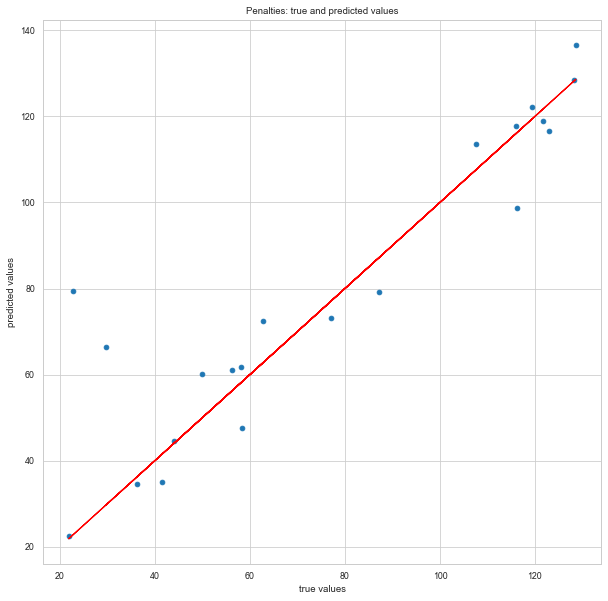

In [73]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test_sm2 = sm.add_constant(X_test2)

# We are making predictions here
y_preds2 = results.predict(X_test_sm2)

plt.scatter(y_test2, y_preds2)
plt.plot(y_test2, y_test2, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Penalties: true and predicted values")
plt.show()

In [74]:
#Linear Regression model
lrm2 = LinearRegression()

# fit method estimates the coefficients using OLS
lrm2.fit(X_train2, y_train2)
# Predicting
y_preds_train2 = lrm2.predict(X_train2)
y_preds_test2 = lrm2.predict(X_test2)

print("R-squared of the model in training set is: {}".format(lrm2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs(
    (y_test2 - y_preds_test2) / y_test2)) * 100))

R-squared of the model in training set is: 0.913862200917691
-----Test set statistics-----
R-squared of the model in test set is: 0.8140657435419817
Mean absolute error of the prediction is: 9.467641171757299
Root mean squared error of the prediction is: 16.198991749626785
Mean absolute percentage error of the prediction is: 24.752503190270588


## Random Forest Model

### Model 1

In [75]:
#intitialize model and fit on training data
rfr = RandomForestRegressor(n_estimators = 5, random_state = 42)

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [76]:
#review predictions
y_preds_train =rfr.predict(X_train)
y_preds_test = rfr.predict(X_test)

print("R-squared of the model in training set is: {}".format(rfr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(rfr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.9882072185801897
-----Test set statistics-----
R-squared of the model in test set is: 0.9910940465321411
Mean absolute error of the prediction is: 3507.805405405407
Root mean squared error of the prediction is: 7309.472760074444
Mean absolute percentage error of the prediction is: 29.853431587267394


In [77]:
print("Cross Val. Scores (10 fold) on Training Set: {}".format(cross_val_score(rfr, X_train, y_train, cv=10)))
print("Cross Val. Scores (10 fold) on Test Set: {}".format(cross_val_score(rfr, X_test, y_test, cv=10)))

Cross Val. Scores (10 fold) on Training Set: [0.9813618  0.97877794 0.94017141 0.95173621 0.95512907 0.95379779
 0.98367866 0.97688153 0.98107301 0.96508288]
Cross Val. Scores (10 fold) on Test Set: [ 9.54795719e-01  8.90872831e-01  8.40952428e-01 -3.38638169e+02
 -6.85638667e+03 -4.22094798e-01  9.67540979e-01  7.80214742e-01
 -6.58666673e-02  7.12200720e-01]


### Model 2

In [78]:
rfr2 = RandomForestRegressor(n_estimators = 5, random_state = 42)

rfr2.fit(X_train2, y_train2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [79]:
y_preds_train2 =rfr2.predict(X_train2)
y_preds_test2 = rfr2.predict(X_test2)

print("R-squared of the model in training set is: {}".format(rfr2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(rfr2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs(
    (y_test2 - y_preds_test2) / y_test2)) * 100))

R-squared of the model in training set is: 0.98249092490412
-----Test set statistics-----
R-squared of the model in test set is: 0.843327883753302
Mean absolute error of the prediction is: 7.3871767869571485
Root mean squared error of the prediction is: 14.869765970050443
Mean absolute percentage error of the prediction is: 22.24220841347829


In [80]:
#look at 10 fold cross validation on training and test data
print("Cross Val. Scores (10 fold) on Training Set: {}".format(cross_val_score(rfr2, X_train2, y_train2, cv=10)))
print("Cross Val. Scores (10 fold) on Test Set: {}".format(cross_val_score(rfr2, X_test2, y_test2, cv=10)))

Cross Val. Scores (10 fold) on Training Set: [ 0.89638572  0.9616138   0.97062809  0.9585503   0.9726264  -0.55729808
  0.95164736  0.17955979  0.94288814  0.7167257 ]
Cross Val. Scores (10 fold) on Test Set: [  0.57304049   0.82482529  -0.31307552   0.84507802  -6.15363274
   0.83557724 -26.18721527 -11.40416527  -1.67064938  -0.04254796]


### Evaluate on full dataset

In [81]:
cv_scores_rfr= cross_val_score(rfr, X, y, cv=10)

print('Accuracy scores for the 10 folds: ',cv_scores_rfr)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores_rfr)))

Accuracy scores for the 10 folds:  [ 1.          1.          1.          1.         -1.77964364  0.45530557
  0.64332452  0.94526625  0.9709863   0.89154835]
Mean cross validatiion score: 0.613


## SVM Regressor

### Model 1

In [82]:
#try SVR on first model
svr = LinearSVR(max_iter=100, random_state=42)
svr.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100,
          random_state=42, tol=0.0001, verbose=0)

In [83]:
y_preds_train =svr.predict(X_train)
y_preds_test = svr.predict(X_test)

print("R-squared of the model in training set is: {}".format(svr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(svr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: -2.932198116360391
-----Test set statistics-----
R-squared of the model in test set is: -3.294800058369608
Mean absolute error of the prediction is: 116474.08838884608
Root mean squared error of the prediction is: 160515.6258018716
Mean absolute percentage error of the prediction is: inf


In [84]:
print("Cross Val. Scores (10 fold) on Training Set: {}".format(cross_val_score(svr, X_train, y_train, cv=10)))
print("Cross Val. Scores (10 fold) on Test Set: {}".format(cross_val_score(svr, X_test, y_test, cv=10)))

Cross Val. Scores (10 fold) on Training Set: [-1.80956324 -1.17241433 -0.98937737 -1.97962627 -1.88669184 -2.4792322
 -1.95126679 -1.39597997 -1.45589897 -2.17456831]
Cross Val. Scores (10 fold) on Test Set: [-3.24021648e-01 -2.13442156e-01  4.14124042e-01 -1.23251677e+03
 -1.04892473e+07 -1.60338100e-01 -1.75341758e+00 -1.28879704e+00
 -5.05356910e+00 -4.43503246e+00]


### Model 2

In [85]:
#run model on second model
svr2 = LinearSVR(max_iter=100, random_state=42)
svr2.fit(X_train2, y_train2)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100,
          random_state=42, tol=0.0001, verbose=0)

In [86]:
y_preds_train2 =svr2.predict(X_train2)
y_preds_test2 = svr2.predict(X_test2)

print("R-squared of the model in training set is: {}".format(svr2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(svr2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs(
    (y_test2 - y_preds_test2) / y_test2)) * 100))

R-squared of the model in training set is: 0.47786907398133877
-----Test set statistics-----
R-squared of the model in test set is: 0.22248515738850205
Mean absolute error of the prediction is: 25.73674123702271
Root mean squared error of the prediction is: 33.125513762031986
Mean absolute percentage error of the prediction is: 60.82157813195151


In [87]:
print("Cross Val. Scores (10 fold) on Training Set: {}".format(cross_val_score(svr2, X_train2, y_train2, cv=10)))
print("Cross Val. Scores (10 fold) on Test Set: {}".format(cross_val_score(svr2, X_test2, y_test2, cv=10)))

Cross Val. Scores (10 fold) on Training Set: [-1.14834353e+02 -2.10220682e+02 -7.93145288e+01 -3.02560116e+02
  3.60513566e-01 -9.80017034e+00  7.01317315e-01 -1.57842127e-01
  1.98836894e-02 -9.34399297e-02]
Cross Val. Scores (10 fold) on Test Set: [ 7.00723715e-01  2.79293503e-01 -1.86760858e+00 -2.33305274e+00
 -3.24382164e+01 -4.83562767e+01 -3.69689687e+04 -1.90967007e+01
  4.69459738e-01 -7.76784275e-01]


In [88]:
#review cross validation scores
cv_scores_svr= cross_val_score(svr, X, y, cv=10)

print('Accuracy scores for the 10 folds: ',cv_scores_svr)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores_svr)))

Accuracy scores for the 10 folds:  [   0.            0.            0.            0.         -207.36387637
   -9.21620898   -4.79004081   -2.34785433   -3.69837264   -1.89865765]
Mean cross validatiion score: -22.932


## Conclusion
All of our models performed poorly with unseen data. The best performer would be Random forest, but the accuracy is still low when comparing to unseen data.